In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [4]:
# Verify data exists
import os
print("Train data exists:", os.path.exists('data/processed/train'))
print("Val data exists:", os.path.exists('data/processed/val'))

Train data exists: True
Val data exists: True


In [5]:
# Create generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    'data/processed/train',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    'data/processed/val',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

print(f"Training samples: {train_gen.samples}")
print(f"Validation samples: {val_gen.samples}")

Found 544 images belonging to 2 classes.
Found 137 images belonging to 2 classes.
Training samples: 544
Validation samples: 137


In [6]:
# Build model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(train_gen, validation_data=val_gen, epochs=5)

# Results
print(f"\nFinal training accuracy: {history.history['accuracy'][-1]:.2%}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.2%}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


c:\Users\tdngo\road-infra-ng\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.9338 - loss: 0.1478 - val_accuracy: 0.9124 - val_loss: 0.2567
Epoch 2/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 33s 920ms/step - accuracy: 0.9908 - loss: 0.0309 - val_accuracy: 0.9197 - val_loss: 0.2517
Epoch 3/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 31s 911ms/step - accuracy: 0.9963 - loss: 0.0226 - val_accuracy: 0.9051 - val_loss: 0.3102
Epoch 4/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 30s 872ms/step - accuracy: 1.0000 - loss: 0.0058 - val_accuracy: 0.9051 - val_loss: 0.3249
Epoch 5/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 30s 871ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.9051 - val_loss: 0.3133

Final training accuracy: 100.00%
Final validation accuracy: 90.51%


Model saved!


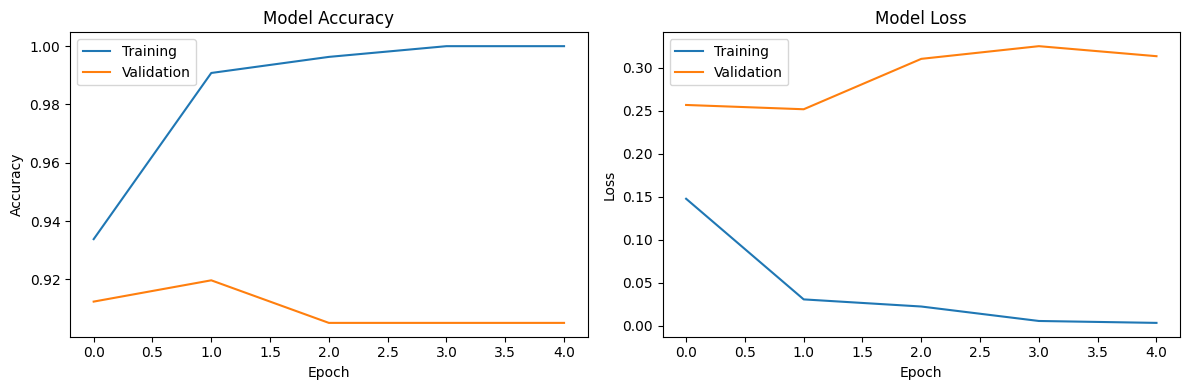

In [8]:
# Save the model
model.save('models/pothole_baseline_v1.h5')
print("Model saved!")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
#plt.savefig('docs/training_results_v1.png')
plt.show()

In [ ]:
import os
from tensorflow.keras.models import load_model

# --- Correct way to reference the model from a subfolder ---

# The key is to use '..' to go up one directory level from your notebook's location
# to the project root, and then go down into the 'models' folder.
# os.path.join is the best way to build paths so they work on any operating system.
model_relative_path = os.path.join('..', 'models', 'pothole_baseline_v1.h5')

print(f"Attempting to load model from relative path: '{model_relative_path}'")

# Let's get the absolute path to be sure where the code is looking
absolute_path = os.path.abspath(model_relative_path)
print(f"Absolute path being checked: '{absolute_path}'")


try:
    # Load the model using the correct relative path
    model = load_model(model_relative_path)
    print("\n✅ Model loaded successfully!")
    
    # You can now proceed with your evaluation code.
    # For example, you can print the model summary to confirm it's loaded.
    # model.summary() 
    
except Exception as e:
    print(f"\n❌ Error loading model: {e}")
    print("\nTroubleshooting tips:")
    print("1. Make sure your notebook is saved in a subfolder (e.g., 'notebooks') inside your main 'road-infra-ng' project folder.")
    print(f"2. Double-check that the model file actually exists at the absolute path shown above.")



In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
import warnings

# --- 1. Configuration ---
# IMPORTANT: Update this path to point to your labeled test dataset directory.
# Example: 'C:/Users/tdngo/road-infra-ng/data/test'
TEST_DATA_DIR = 'data/processed/val'  

MODEL_PATH = '../models/pothole_baseline_v1.h5'

# --- Suppress warnings for a clean output ---
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore')

# --- 2. Load the Model ---
print(f" Loading model from '{MODEL_PATH}'...")
try:
    model = load_model(MODEL_PATH)
    print("Model loaded successfully.")
except Exception as e:
    print(f" Error loading model: {e}")
    model = None

# --- 3. Load Data and Generate Report ---
if model:
    if not os.path.exists(TEST_DATA_DIR) or not os.listdir(TEST_DATA_DIR):
        print(f" Error: Test data directory not found or is empty at '{TEST_DATA_DIR}'")
        print("Please update the TEST_DATA_DIR variable with the correct path.")
    else:
        print(f" Loading test data from '{TEST_DATA_DIR}'...")
        # Load the test dataset from the directory
        test_dataset = tf.keras.utils.image_dataset_from_directory(
            TEST_DATA_DIR,
            labels='inferred',
            label_mode='binary',
            image_size=(224, 224),
            batch_size=32,
            shuffle=False  # Keep data in order for evaluation
        )
        class_names = test_dataset.class_names
        print(f"Found classes: {class_names}")

        # --- Get True Labels and Predicted Labels ---
        print("  Running predictions to generate report...")
        
        # Extract the true labels (y_true) from the dataset
        y_true = np.concatenate([y for x, y in test_dataset], axis=0).flatten()
        
        # Get the model's predictions (y_pred)
        y_pred_probs = model.predict(test_dataset, verbose=0)
        y_pred = (y_pred_probs > 0.5).astype(int).flatten()

        # --- 4. Generate and Print ONLY the Classification Report ---
        print("\n" + "="*50)
        print(" Classification Report")
        print("="*50)
        
        # This is the core output you requested
        report = classification_report(y_true, y_pred, target_names=class_names)
        print(report)
        
        print("="*50)


 Loading model from '../models/pothole_baseline_v1.h5'...


Model loaded successfully.
 Loading test data from 'data/processed/val'...
Found 137 files belonging to 2 classes.
Found classes: ['normal', 'pothole']
  Running predictions to generate report...

 Classification Report
              precision    recall  f1-score   support

      normal       0.95      0.25      0.40        71
     pothole       0.55      0.98      0.71        66

    accuracy                           0.61       137
   macro avg       0.75      0.62      0.55       137
weighted avg       0.76      0.61      0.55       137

